## Yolov8 Client

This example shows how to run [Yolov8](https://docs.ultralytics.com/) by Ultralytics on a remote PyTriton server. Similar to the previous examples, the image will be loaded from client side and transmitted to the server over http for inference. The server returns the following:

* `bboxes` - an array of bounding boxes. Each item refers to detected object in MSCOCO 80 classes.
* `probs` - an array of probabilities for each detected object.
* `names` - a `|` - separated of names of detected objects.

In [48]:
import cv2
import numpy as np
import urllib.request
import validators
import matplotlib.pyplot as plt
from pytriton.client import ModelClient

### Enter image path

Either from filesystem or url (eg `https://djl.ai/examples/src/test/resources/dog_bike_car.jpg`)

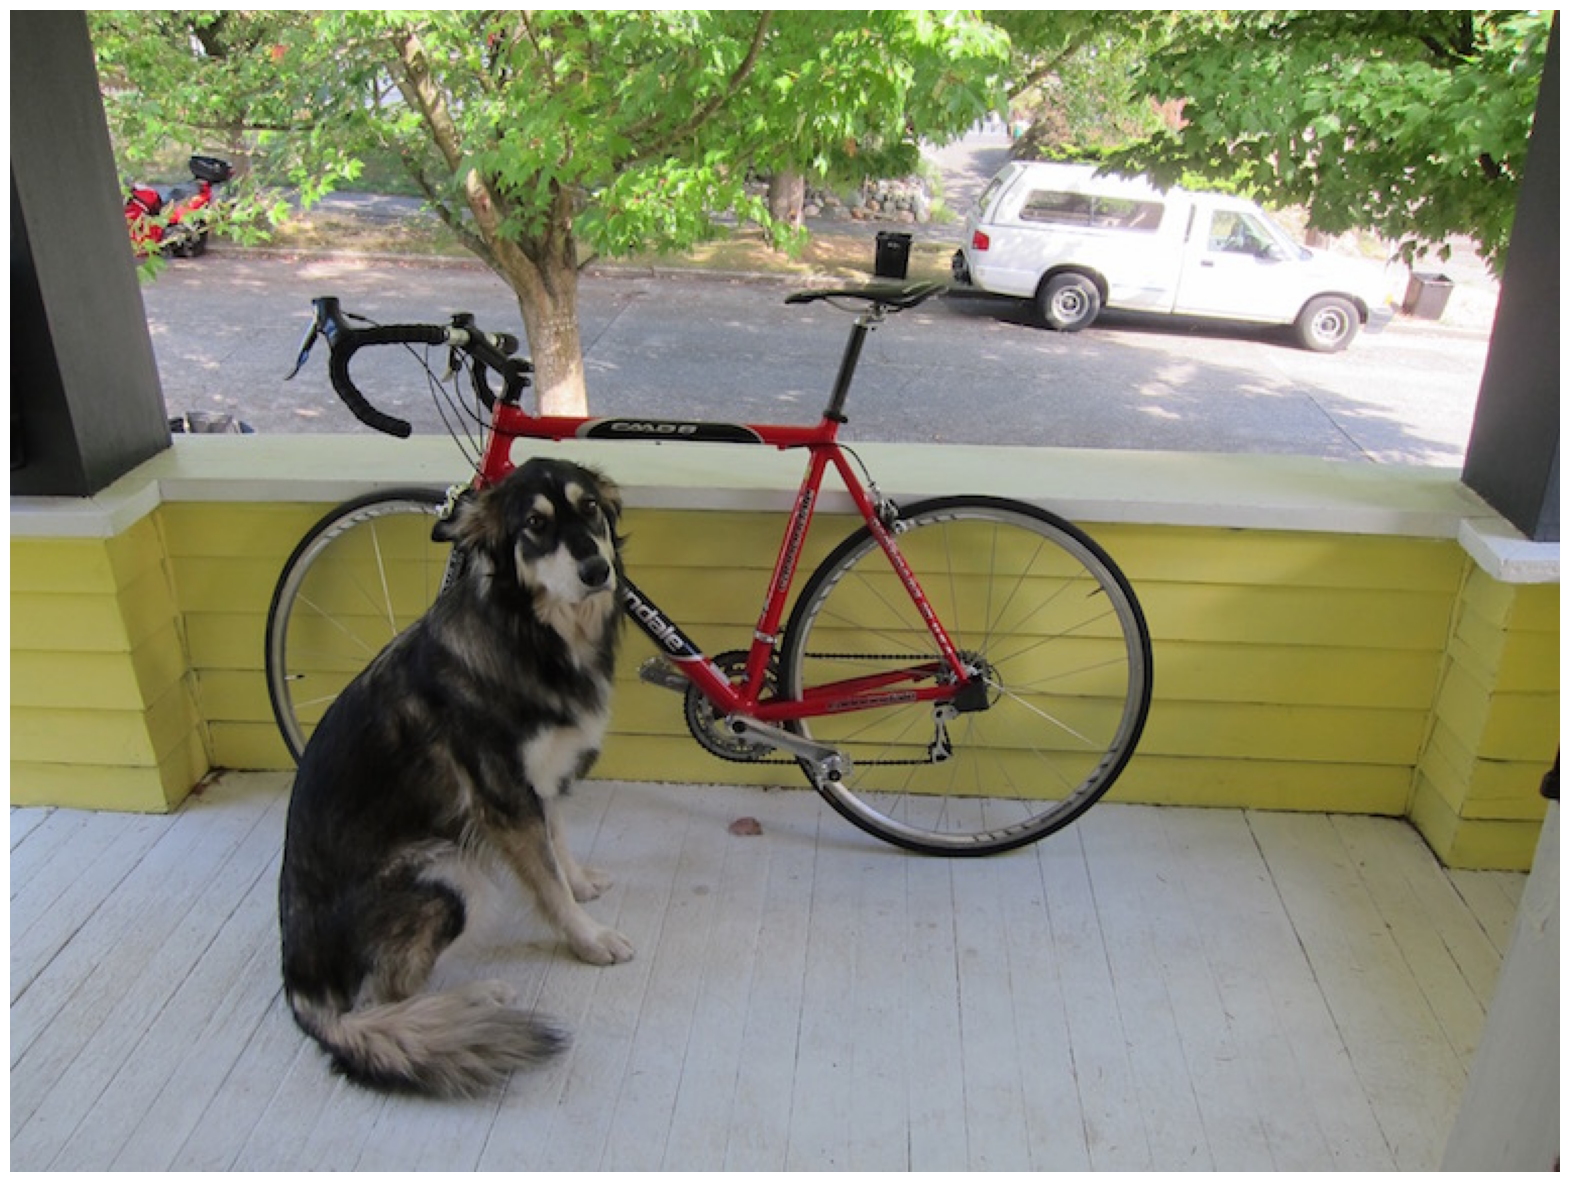

In [49]:
image_path = input("Enter image path: ")
# if empty, use default
if image_path == "":
    image_path = "../sam/images/dog_car.jpg"
    
if validators.url(image_path):
    with urllib.request.urlopen(image_path) as url_response:
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        image = cv2.imdecode(img_array, -1)
else:
    image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

#### Client call to inference server

In [50]:
def infer_model(url="http://localhost:8000", image="../sam/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
                
                
                

Call the server with the image

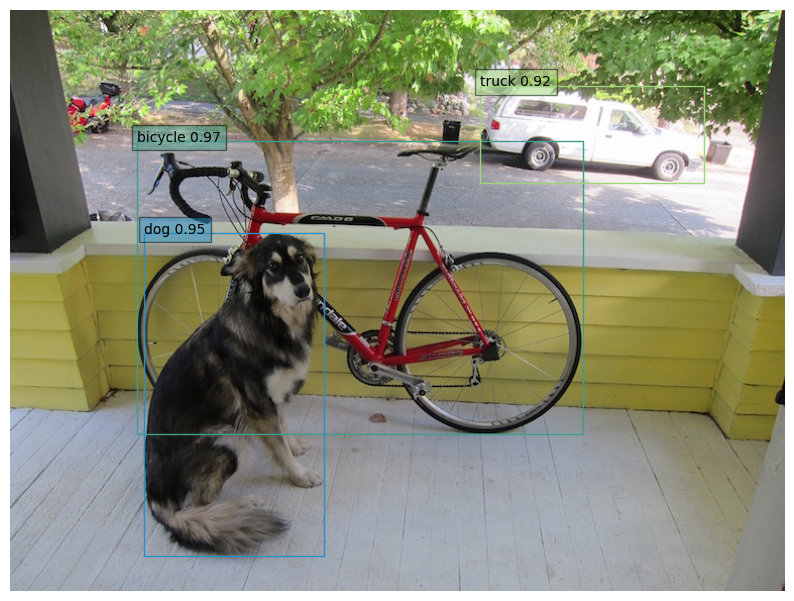

In [51]:
infer_model(image=image_path)